# Gold ETC analysis
Recently I found a new asian gold ETC with low volume. 
The low volume seems to create some arbitrage / spread opportunities.
This study is going to determine if possible to make some money exploiting those opportunities

## 1. Initialisation




In [112]:
%%capture
import time
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import pandas as pd
from datetime import timedelta, datetime
! pip install yfinance # install yfinance during the  init
import yfinance as yf
import numpy as np
from os import path

## 2 acquirering the data
this small gold ETC can be exchanged 24/7 compared to big one like the goldman sack AAAU.
Moreover I could not found a big dataset of hourly data for AAAU, so for the beggining of the study I'm gonna start with a daily data.

In [2]:
#download price gold
Df = yf.download('AAAU', '2019-10-29', '2021-03-31', auto_adjust=True, prepost=True)

[*********************100%***********************]  1 of 1 completed


In [74]:
# historical data from the gold etc
df = pd.read_csv('GoldETC.csv')
df.columns = ['Date', 'price', 'Volume']
for i in ['Open','High','Low','Close']:
  df[i] = df['price']
df['Date'] = pd.to_datetime(df['Date'],unit='s')  
#Converts the timestamp column to the correct format
ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
df = df.set_index("Date")
#df.index = df.index - timedelta(hours=10)
df = df.resample('1h', closed='left', label='left').apply(ohlc_dict) 
df = df.dropna()

The idea is simple, create a delta between the etc and AAAU: Buy when etc undervalue, Sell when overvalued

In [77]:
#need to make sure the timezone is the same
new_df = pd.merge(df, Df, how='outer', on='Date')
new_df = new_df.sort_values(by=['Date'])
new_df['Delta']= (new_df['Close_x'] - new_df['Close_y']*100)/(new_df['Close_y']*100)
new_df.dropna(inplace=True)

Text(0.5, 1.0, 'Delta')

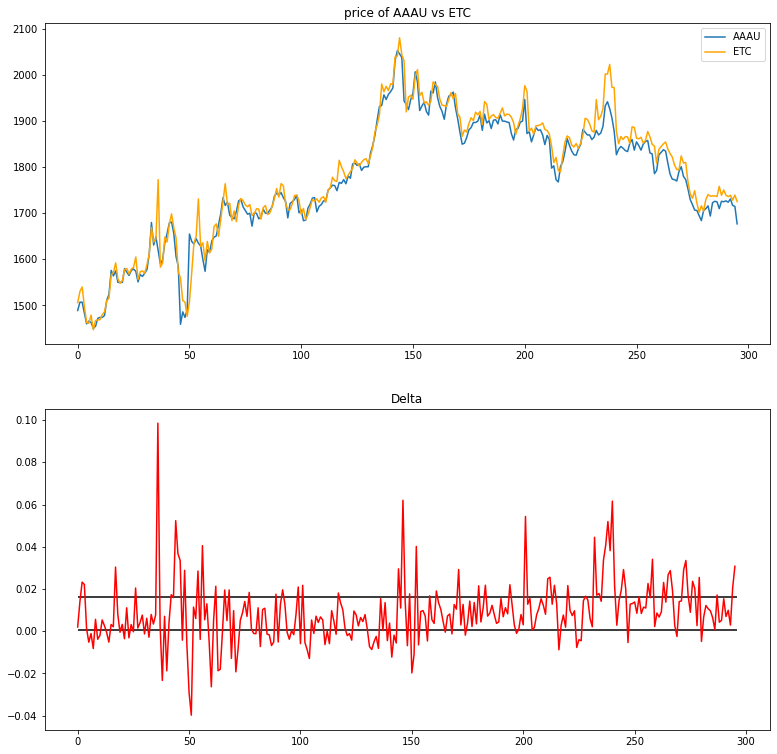

In [110]:
figure, axis = plt.subplots(2,figsize=(13,13))
axis[0].plot(new_df['Open_y'].values[:]*100,label='AAAU')
axis[0].plot(new_df['Open_x'].values[:], label='ETC',color='orange')
axis[0].legend()
axis[0].set_title("price of AAAU vs ETC")
axis[1].plot(new_df['Delta'].values,color='red')
axis[1].hlines(0.0008,0,len(new_df))
axis[1].hlines(0.016,0,len(new_df))
axis[1].set_title("Delta")

## 3. Arbitrage

The price of gold seems to bounces around the price of gold (see delta). Let's try with those two values 0.0008 and 0.016 and see how the simulation goes

In [ ]:
initial_investment = 2000
start = 0
end = -1
parameter_a = 0.0008
parameter_b = 0.016
number_days = (new_df.index[end]-new_df.index[start]).days
print('number of days is ',number_days)
delta = new_df['Delta'].values[start:end]
price = new_df['Close_x'].values[start:end]
volume_etc = new_df['Volume_x'].values[start:end]
usd = initial_investment
gold=0
volume=0
buy_list=[]
sell_list=[]
wallet_list =[]


for i in range(len(delta)):
  if delta[i]< parameter_a:
    if usd !=0:
      # only take 3% of the total volume supply
      invest = min(usd,volume_etc[i]*price[i]*0.03)
      #buy gold
      volume += invest
      # the is a 0.15% fees on the broker
      gold = invest / price[i] * (1-0.15/100) + gold
      usd = usd - invest
      buy_list+=[price[i]]
      sell_list+=[np.nan]
    else:
      buy_list+=[np.nan]
      sell_list+=[np.nan]
  elif delta[i]> parameter_b :
    if gold !=0:
      invest = min(gold,volume_etc[i]*0.03)
      #sell gold
      usd = invest * price[i] * (1-0.15/100) + usd
      volume += invest
      gold = gold - invest
      #print(usd + gold*price[i])
      buy_list+=[np.nan]
      sell_list+=[price[i]]
    else:
      buy_list+=[np.nan]
      sell_list+=[np.nan]
  else:
      buy_list+=[np.nan]
      sell_list+=[np.nan]
  wallet = usd + gold*price[i]
  wallet_list += [wallet]
roi = (((wallet -initial_investment )/initial_investment))
volume = volume/number_days*30

print(wallet)
print('monthly volume is ',volume)
print('ROI',roi)

number of days is  517
2434.540160035197
monthly volume is  400.5530361328063
ROI 0.2172700800175985


ROI wallet : 21.7 %
ROI if buy gold at t=0 : 16.113 %


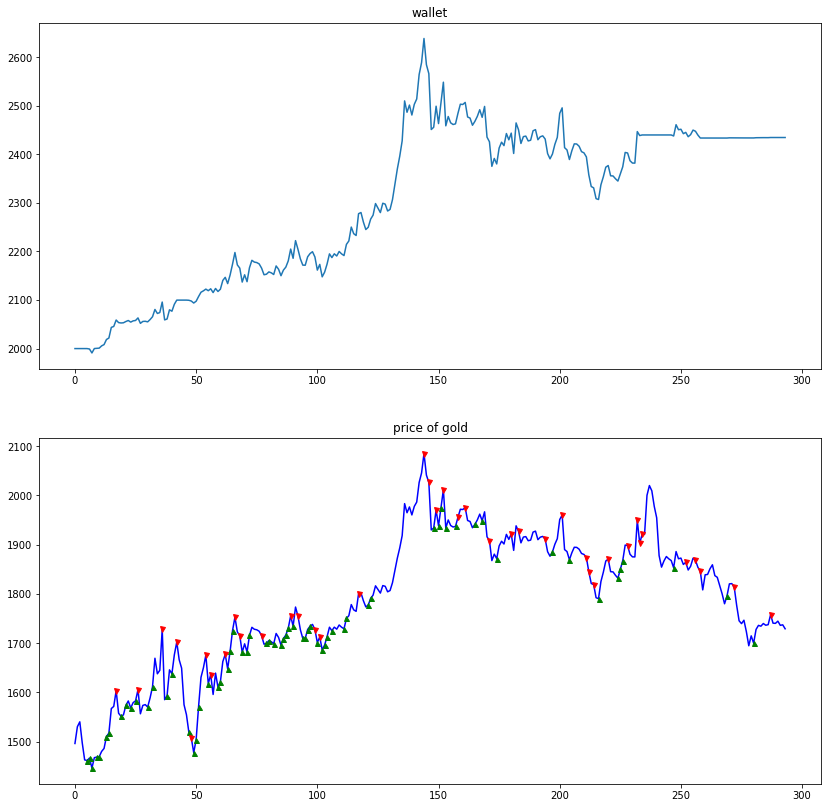

In [ ]:
start=0
end=-1
figure, axis = plt.subplots(2,figsize=(14,14))
axis[0].plot(wallet_list[start:end])
axis[0].set_title("wallet")
axis[1].plot(price[start:end], color='b')
axis[1].plot((np.array(buy_list))[start:end], '^', markersize=5, color='g')
axis[1].plot((np.array(sell_list))[start:end], 'v', markersize=5, color='r')
axis[1].set_title("price of gold")
print('ROI wallet :', round(roi*100,1),"%")
print('ROI if buy gold at t=0 :', round((price[-1]-price[0])/price[0]*100,3),'%')

The result are bad, is almost the same as not having an algorithm at all. 
<br> This was predicted because arbitrage opportunities need hourly data at least.
<br><br> <u> Idea for improvement </u>The yahoo api allows to pull hourly data only the last couple of days. I already have a data miner set up on my raspberry pi to take data from different brokers. I'm adding those two pairs to it and redo the study in a couple of weeks.

## 2. Spread exploitation
In the mean time lets try to take advantage of this spread and the low volume. At first I thought using something similar to the avellaneda stoikov market making algorithm. However it's not a really good method in that case because of the high fees. 
<br> Instead I thought about using something way more simple. Take advantage of the spikes and put a market order at x% around the current price

In [93]:
df = pd.read_csv('GoldETC.csv')
df.columns = ['Date', 'price', 'Volume']
for i in ['Open','High','Low','Close']:
  df[i] = df['price']
df['Date'] = pd.to_datetime(df['Date'],unit='s')  
#Converts the timestamp column to the correct format
ohlc_dict = {
            'Open': 'first',
            'High': 'max',
            'Low': 'min',
            'Close': 'last',
            'Volume': 'sum'
        }
df = df.set_index("Date")
df = df.resample('1h', closed='left', label='left').apply(ohlc_dict)
df = df.dropna() 
df['delta_high']=(df['High']-df['High'].shift(1))/df['High'].shift(1)
df['delta_low']=(df['Low']-df['Low'].shift(1))/df['Low'].shift(1)
df['Avg']= (df['High']+df['Low'])/2
df['trig'] = (df['Avg'] - df['Avg'].shift(1))/df['Avg'].shift(1)
df = df.dropna()

In [61]:
new_df = pd.merge(df, etf, how='outer', on='Date')
new_df = new_df.sort_values(by=['Date'])
new_df['Delta']= (new_df['Open_x'] - new_df['Open_y']*100)/(new_df['Open_y']*100)
new_df.dropna(inplace=True)
new_df['Delta']= new_df['Delta']
new_df.dropna(inplace=True)

In [107]:
initial_investment = 2000
start = 1
end = -1
parameter_a = -0.0035
parameter_b = 0.016
df.dropna(inplace=True)
number_days = (df.index[end]-df.index[start]).days
print('number of days is ',number_days)
High = df['High'].values[start:end]
Avg = df['Avg'].values[start:end]
Low = df['Low'].values[start:end]
delta_high = df['delta_high'].values[start:end]
delta_low = df['delta_low'].values[start:end]
price = df['Close'].values[start:end]
volume_etc = df['Volume'].values[start:end]
usd = initial_investment
volume=0
wallet_list = []
gold=0
buy_list=[]
sell_list=[]
for i in range(0,len(High)):
  if delta_low[i]<parameter_a:#(Low[i-1] - Low[i])/Low[i] > 0.005:
    if  usd!=0:
      invest = min(usd,volume_etc[i]*price[i]*0.03)
      #buy gold
      volume += invest
      gold = invest / (Low[i-1]*(1+parameter_a))* (1-0.16/100) + gold
       usd -= invest
      buy_list+=[Low[i-1]*(1+parameter_a)]
      sell_list+=[np.nan]
    else:
      buy_list+=[np.nan]
      sell_list+=[np.nan]
  elif delta_high[i] > parameter_b:
    if gold !=0:
      invest = min(gold,volume_etc[i]*0.03)
      #sell gold
      usd = invest * (High[i-1]*(1+parameter_b))* (1-0.16/100) + usd
      volume += invest
      gold -= invest
      buy_list+=[np.nan]
      sell_list+=[High[i-1]*(1+parameter_b)]
      #print( + gold*price[i])
    else:
      buy_list+=[np.nan]
      sell_list+=[np.nan]
  else:
      buy_list+=[np.nan]
      sell_list+=[np.nan]
  wallet =  + gold*price[i]
  wallet_list += [wallet]
volume = volume/number_days*30
roi = ((wallet -initial_investment )/initial_investment)
print(wallet)
print('monthly volume is ',volume)
print('ROI',roi)

number of days is  518
3338.3201825896704
monthly volume is  4181.340757992532
ROI 0.6691600912948352


ROI wallet : 66.9 %
ROI if buy gold at t=0 : 14.6 %


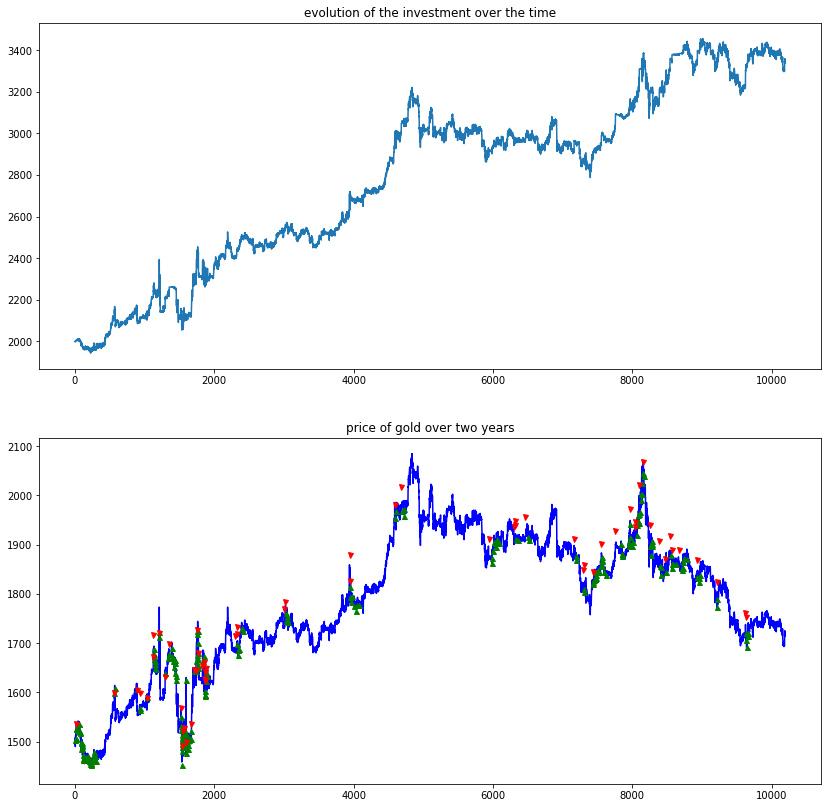

In [109]:
figure, axis = plt.subplots(2,figsize=(14,14))
axis[0].plot(wallet_list,label='wallet (PnL)')
axis[0].set_title("evolution of the investment over the time (PnL)")
axis[1].plot(price,color='blue', label='price gold')
axis[1].set_title("price of gold over two years")
axis[1].plot((np.array(buy_list))[start:end], '^', markersize=5, color='g')
axis[1].plot((np.array(sell_list))[start:end], 'v', markersize=5, color='r')
print('ROI wallet :', round(roi*100,1),"%")
print('ROI if buy gold at t=0 :', round((price[-1]-price[0])/price[0]*100,1),'%')

This simple market maker gives way better result. Over a period of 500 days there is a 67% profit (fee included) while the market make only 15%
<br> To improve the result, I can try to create some dynamic parameter for delta instead of fixed ones.

## 4. After two weeks of data mining here are the result
The result are similar than with the daily dataset. The algorithm doesn't beat the market

## 5. Conclusion
The spread exploitation give some very good result. The only drawback is the limitation of volume that can be put on the pair. The more I put and the less profitable it become.